In [1]:
# Importing necessary libraries

import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### GPU Availability

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


### Data Augmentation

In [3]:

imgSize = 112
# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Loading Dataset

In [4]:
path = '/kaggle/input/melanoma-cancer-dataset/train'
valPath = '/kaggle/input/melanoma-cancer-dataset/test'

trainData = datasets.ImageFolder(root = path, transform = transformer)
valData = datasets.ImageFolder(root = valPath, transform = valTransformer)

In [5]:
# Data loaders
batchSize = 256

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

# Defining Model

In [6]:
# Using a pre-trained EfficientNetV2L model
model1 = models.vgg16(weights = 'DEFAULT')

# Modifying final classifier layer
model1.classifier[6] = nn.Linear(model1.classifier[6].in_features, 1)

model2= models.resnet50(weights='DEFAULT')
in_features= model2.fc.in_features
model2.fc= nn.Linear(in_features, 1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 328MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, input_channels=3):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=7, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2)

        self._init_fc_layers()

    def _forward_conv(self, x):
        x = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.leaky_relu(self.bn5(self.conv5(x))))

        return x

    def _init_fc_layers(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 112, 112) 
            dummy = self._forward_conv(dummy)
            flatten_size = dummy.view(1, -1).size(1)

        self.fc1 = nn.Linear(flatten_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)  
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        return x


### Data Parallelism

In [8]:
model1 = nn.DataParallel(model1).to(device)
model2 = nn.DataParallel(model2).to(device)
model3 = CustomCNN(input_channels=3).to(device)
model3 = nn.DataParallel(model3)

In [9]:
# Defining the loss, optimizer, and annealer
criterion = nn.BCEWithLogitsLoss()

optimizer1 = optim.Adam(model1.parameters(), lr = 0.001)
optimizer2 = optim.Adam(model2.parameters(), lr = 0.001)
optimizer3 = optim.Adam(model2.parameters(), lr = 0.001)

scheduler1 = ReduceLROnPlateau(optimizer1, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)
scheduler2 = ReduceLROnPlateau(optimizer2, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)
scheduler3 = ReduceLROnPlateau(optimizer3, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

### Early Stopping

In [10]:
patience = 5
minDelta = 0.01

currentPatience1 = 0
bestLoss1 = float('inf')

currentPatience2 = 0
bestLoss2 = float('inf')

currentPatience3 = 0
bestLoss3 = float('inf')

# Training Model

In [11]:
# Gradient scaler for mixed-precision training
scaler1 = GradScaler()
scaler2 = GradScaler()
scaler3 = GradScaler()


# Lists to store training and validation metrics
trainLosses1 = []
valLosses1 = []
valAccs1 = []

trainLosses2 = []
valLosses2 = []
valAccs2= []

trainLosses3 = []
valLosses3 = []
valAccs3 = []

# Training loop
epochs = 40

for epoch in range(epochs):
    # Training phase
    model1.train()
    model2.train()
    model3.train()
    
    runningLoss1 = 0.0
    runningLoss2= 0.0
    runningLoss3= 0.0


    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()

        with autocast():
            outputs1 = model1(inputs)
            loss1 = criterion(outputs1, labels)

            outputs2 = model2(inputs)
            loss2 = criterion(outputs2, labels)

            outputs3 = model3(inputs)
            loss3 = criterion(outputs3, labels)

        scaler1.scale(loss1).backward()
        scaler1.step(optimizer1)
        scaler1.update()

        scaler2.scale(loss2).backward()
        scaler2.step(optimizer2)
        scaler2.update()
        
        scaler3.scale(loss3).backward()
        scaler3.step(optimizer3)
        scaler3.update()
        
        runningLoss1 += loss1.item()
        runningLoss2 += loss2.item()
        runningLoss3 += loss3.item()

    trainLoss1 = runningLoss1 / len(trainLoader)
    trainLoss2 = runningLoss2 / len(trainLoader)
    trainLoss3 = runningLoss3 / len(trainLoader)

    
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss vgg16: {trainLoss1:.2f},Training Loss resnet50: {trainLoss2:.2f}, Training Loss custom cnn: {trainLoss3:.2f}')
    trainLosses1.append(trainLoss1)
    trainLosses2.append(trainLoss2)
    trainLosses3.append(trainLoss3)


    # Validation phase
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        valLoss1 = 0.0
        valLoss2 =0.0
        valLoss3 =0.0

        correct1 = total1 = 0
        correct2 = total2 = 0
        correct3 = total3 = 0


        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs1 = model1(inputs)
            loss1 = criterion(outputs1, labels)
            valLoss1 += loss1.item()

            predicted1 = (torch.sigmoid(outputs1) > 0.5).float()
            total1 += labels.size(0)
            correct1 += (predicted1 == labels).sum().item()
            

            outputs2 = model2(inputs)
            loss2 = criterion(outputs2, labels)
            valLoss2 += loss2.item()

            predicted2 = (torch.sigmoid(outputs2) > 0.5).float()
            total2 += labels.size(0)
            correct2 += (predicted2 == labels).sum().item()
            
            outputs3 = model3(inputs)
            loss3 = criterion(outputs3, labels)
            valLoss3 += loss3.item()

            predicted3 = (torch.sigmoid(outputs3) > 0.5).float()
            total3 += labels.size(0)
            correct3 += (predicted3 == labels).sum().item()
        
        avgLoss1 = valLoss1 / len(valLoader)
        accuracy1 = correct1 / total1 * 100
        
        avgLoss2 = valLoss2 / len(valLoader)
        accuracy2 = correct2 / total2 * 100
        
        avgLoss3 = valLoss3 / len(valLoader)
        accuracy3 = correct3 / total3 * 100

        print(f' Vgg16 Validation Loss : {avgLoss1:.2f} Validation Accuracy : {accuracy1:.2f}%\n')
        print(f'Resnet50 Validation Loss : {avgLoss2:.2f} Validation Accuracy : {accuracy2:.2f}%\n')
        print(f'custom cnn Validation Loss : {avgLoss3:.2f} Validation Accuracy : {accuracy3:.2f}%\n')

        valLosses1.append(avgLoss1)
        valAccs1.append(accuracy1)
        
        valLosses2.append(avgLoss2)
        valAccs2.append(accuracy2)
        
        valLosses3.append(avgLoss3)
        valAccs3.append(accuracy3)

        # Early stopping
        if avgLoss1 < bestLoss1 - minDelta:
            bestLoss1 = avgLoss1
            currentPatience1 = 0
        else:
            currentPatience1 += 1
            if currentPatience1 >= patience:
                print('Early stopping triggered.')
                break

        scheduler1.step(avgLoss1)
        
        if avgLoss2 < bestLoss2 - minDelta:
            bestLoss2 = avgLoss2
            currentPatience2 = 0
        else:
            currentPatience2 += 1
            if currentPatience2 >= patience:
                print('Early stopping triggered.')
                break

        scheduler2.step(avgLoss2)

        if avgLoss3 < bestLoss3 - minDelta:
            bestLoss3 = avgLoss3
            currentPatience3 = 0
        else:
            currentPatience3 += 1
            if currentPatience3 >= patience:
                print('Early stopping triggered.')
                break

        scheduler3.step(avgLoss3)

Epoch 1/40 - Training Loss vgg16: 2.19,Training Loss resnet50: 0.31, Training Loss custom cnn: 0.69
 Vgg16 Validation Loss : 0.69 Validation Accuracy : 50.75%

Resnet50 Validation Loss : 0.33 Validation Accuracy : 87.70%

custom cnn Validation Loss : 0.69 Validation Accuracy : 50.00%

Epoch 2/40 - Training Loss vgg16: 0.57,Training Loss resnet50: 0.23, Training Loss custom cnn: 0.69
 Vgg16 Validation Loss : 0.60 Validation Accuracy : 67.30%

Resnet50 Validation Loss : 0.43 Validation Accuracy : 81.45%

custom cnn Validation Loss : 0.69 Validation Accuracy : 50.00%

Epoch 3/40 - Training Loss vgg16: 0.37,Training Loss resnet50: 0.21, Training Loss custom cnn: 0.69
 Vgg16 Validation Loss : 0.52 Validation Accuracy : 75.90%

Resnet50 Validation Loss : 0.21 Validation Accuracy : 93.55%

custom cnn Validation Loss : 0.69 Validation Accuracy : 50.00%

Epoch 4/40 - Training Loss vgg16: 0.32,Training Loss resnet50: 0.20, Training Loss custom cnn: 0.69
 Vgg16 Validation Loss : 0.31 Validation A

# evaluation metrics

In [12]:
model1.eval()
allLabels = []
allPreds1 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs1 = model1(inputs)
        predictions1 = (torch.sigmoid(outputs1) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds1.extend(predictions1.cpu().numpy())

allLabels = np.array(allLabels)
allPreds1 = np.array(allPreds1)


# Accuracy
accuracy = accuracy_score(allLabels, allPreds1)  
print(f'Accuracy: {accuracy:.4f}')  

# Precision
precision = precision_score(allLabels, allPreds1, average='binary')  
print(f'Precision: {precision:.4f}')  

# Recall
recall = recall_score(allLabels, allPreds1, average='binary')  
print(f'Recall: {recall:.4f}')  

# F1 Score
f1 = f1_score(allLabels, allPreds1, average='binary')  
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7970
Precision: 0.9527
Recall: 0.6250
F1 Score: 0.7548


In [13]:
model2.eval()
allLabels = []
allPreds2 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs2 = model2(inputs)
        predictions2 = (torch.sigmoid(outputs2) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds2.extend(predictions2.cpu().numpy())

allLabels = np.array(allLabels)
allPreds2 = np.array(allPreds2)


# Accuracy
accuracy = accuracy_score(allLabels, allPreds2)  
print(f'Accuracy: {accuracy:.4f}')  

# Precision
precision = precision_score(allLabels, allPreds2, average='binary')  
print(f'Precision: {precision:.4f}')  

# Recall
recall = recall_score(allLabels, allPreds2, average='binary')  
print(f'Recall: {recall:.4f}')  

# F1 Score
f1 = f1_score(allLabels, allPreds2, average='binary')  
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9180
Precision: 0.9283
Recall: 0.9060
F1 Score: 0.9170


In [14]:
model3.eval()
allLabels = []
allPreds3 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs3 = model3(inputs)
        predictions3 = (torch.sigmoid(outputs3) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds3.extend(predictions3.cpu().numpy())

allLabels = np.array(allLabels)
allPreds3 = np.array(allPreds3)


# Accuracy
accuracy = accuracy_score(allLabels, allPreds3)  
print(f'Accuracy: {accuracy:.4f}')  

# Precision
precision = precision_score(allLabels, allPreds3, average='binary')  
print(f'Precision: {precision:.4f}')  

# Recall
recall = recall_score(allLabels, allPreds3, average='binary')  
print(f'Recall: {recall:.4f}')  

# F1 Score
f1 = f1_score(allLabels, allPreds3, average='binary')  
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


# visualisation

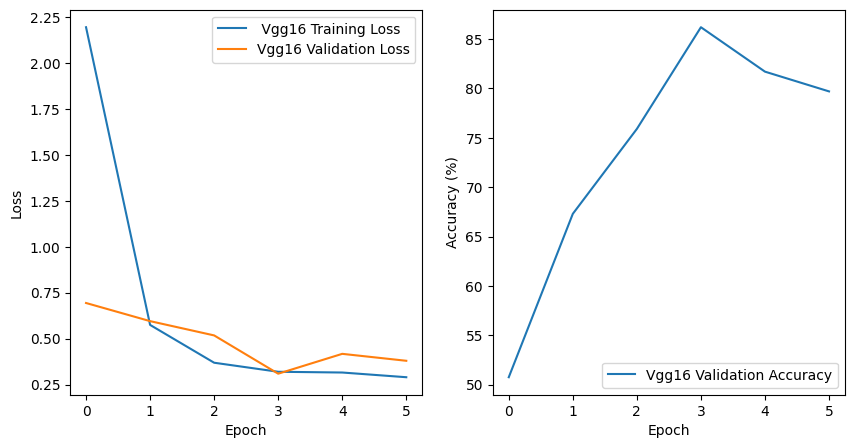

In [15]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses1, label = ' Vgg16 Training Loss')
plt.plot(valLosses1, label = 'Vgg16 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs1, label = 'Vgg16 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

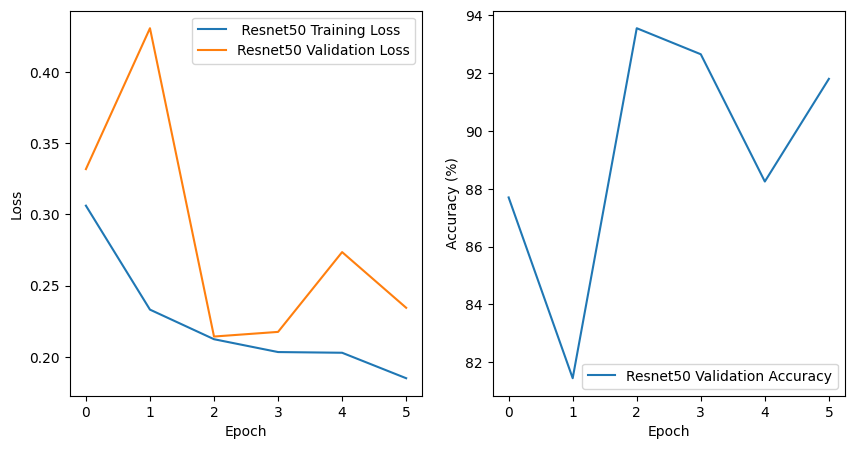

In [16]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses2, label = ' Resnet50 Training Loss')
plt.plot(valLosses2, label = 'Resnet50 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs2, label = 'Resnet50 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

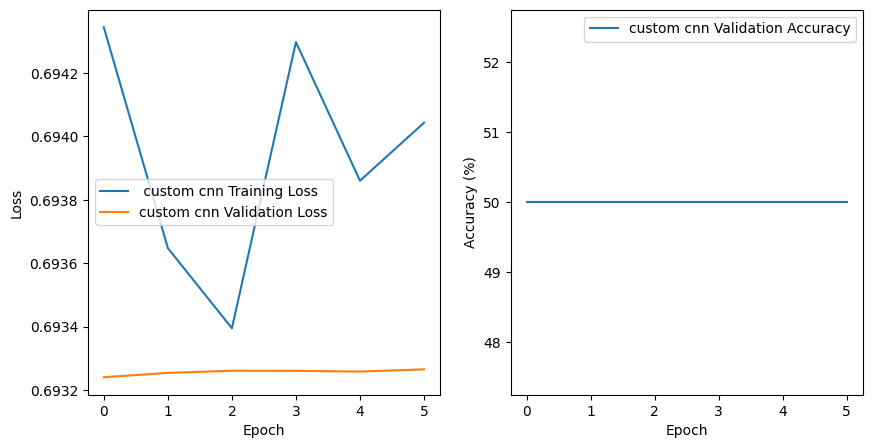

In [17]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses3, label = ' custom cnn Training Loss')
plt.plot(valLosses3, label = 'custom cnn Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs3, label = 'custom cnn Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# confusion matrices

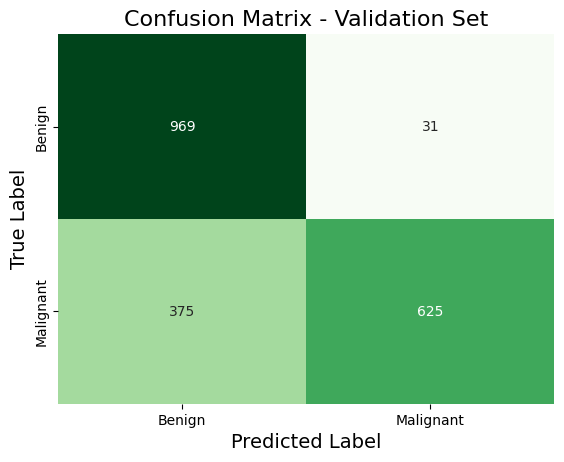

In [18]:
# Plotting confusion matrix for validation data
model1.eval()
allLabels = []
allPreds1 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs1 = model1(inputs)
        predictions1 = (torch.sigmoid(outputs1) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds1.extend(predictions1.cpu().numpy())

allLabels = np.array(allLabels)
allPreds1 = np.array(allPreds1)

matrix1 = confusion_matrix(allLabels, allPreds1)

sns.heatmap(matrix1, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

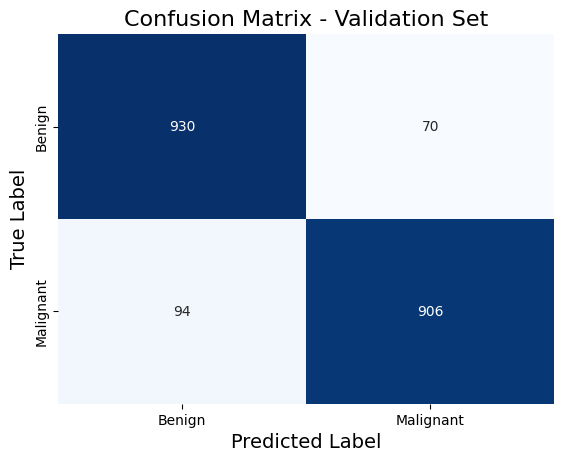

In [19]:
model2.eval()
allLabels = []
allPreds2 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs2 = model2(inputs)
        predictions2 = (torch.sigmoid(outputs2) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds2.extend(predictions2.cpu().numpy())

allLabels = np.array(allLabels)
allPreds2 = np.array(allPreds2)

matrix2 = confusion_matrix(allLabels, allPreds2)

sns.heatmap(matrix2, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

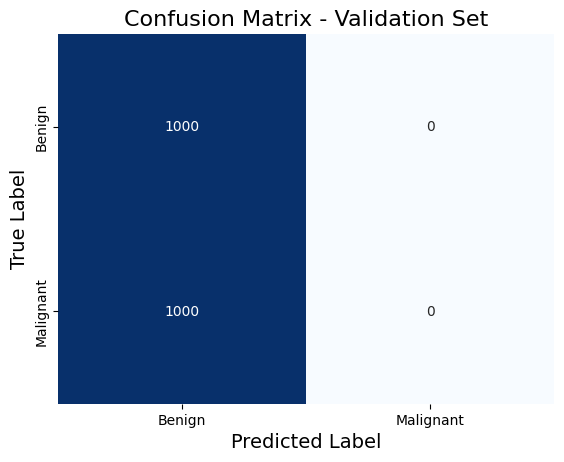

In [20]:
model3.eval()
allLabels = []
allPreds3 = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs3 = model3(inputs)
        predictions3 = (torch.sigmoid(outputs3) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds3.extend(predictions3.cpu().numpy())

allLabels = np.array(allLabels)
allPreds3 = np.array(allPreds3)

matrix3 = confusion_matrix(allLabels, allPreds3)

sns.heatmap(matrix3, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

# ensemble

In [21]:
models = [model1, model2, model3]
#create_ensemble
allPreds = []

for model in models:
    model.eval()

with torch.no_grad():
    for inputs, _ in valLoader:
        inputs = inputs.to(device)
        batch_preds = []

        for model in models:
            outputs = model(inputs)
            probs = torch.sigmoid(outputs) 
            batch_preds.append(probs)

        
        batch_preds = torch.stack(batch_preds, dim=0)
        batch_mean = batch_preds.mean(dim=0)

        
        preds = (batch_mean > 0.5).long()
        allPreds.append(preds.cpu())


final_preds = torch.cat(allPreds, dim=0)



In [22]:
# evaluate_ensemble
y_true = []

for _, labels in valLoader:
    y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)

print(f"\n{'='*40}")
print(f"Evaluating Ensemble")
print(f"{'='*40}")

# Metrics
acc = accuracy_score(y_true, final_preds)
precision = precision_score(y_true, final_preds)
recall = recall_score(y_true, final_preds)
f1 = f1_score(y_true, final_preds)

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")




Evaluating Ensemble
Accuracy: 90.90%
Precision: 0.9398
Recall: 0.8740
F1 Score: 0.9057



Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.94      0.91      1000
   Malignant       0.94      0.87      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



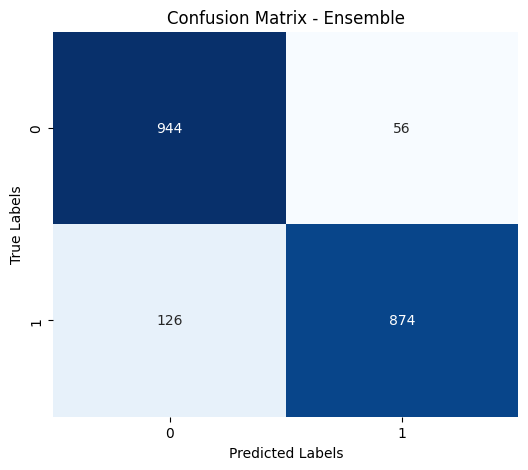

In [23]:
from sklearn.metrics import classification_report
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, final_preds, target_names=['Benign', 'Malignant']))

# Confusion Matrix
cm = confusion_matrix(y_true, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Ensemble')
plt.show()